In [1]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.neighbors.kde import KernelDensity

%matplotlib inline
plt.style.use('ggplot')
np.random.seed(1234)

In [2]:
PATH = '/Users/disiji/Dropbox/current/flow_cytometry/acdc/data/'

In [44]:
# load AML data and table
##### X: np.array, flow cytometry data, arcsin transformed
##### T: table of expert knowledge
channels = ['CD45','CD45RA', 'CD19', 'CD11b', 'CD4', 'CD8', 'CD34',
           'CD20', 'CD33', 'CD123', 'CD38', 'CD90', 'CD3']
path = PATH + 'AML_benchmark/'
df = pd.read_csv(path + 'AML_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip')
## discard ungated events
df = df[df.cell_type != 'NotGated']

df = df.drop(['Time', 'Cell_length','file_number', 'event_number', 'DNA1(Ir191)Di',
              'DNA2(Ir193)Di', 'Viability(Pt195)Di', 'subject'], axis = 1)

channels = [item[:item.find('(')] for item in df.columns[:-1]]
df.columns = channels + ['cell_type']

df = df.loc[df['cell_type'] != 'NotDebrisSinglets']

table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)
table = table.fillna(0)
X = df[channels].values

print X.shape

(104184, 32)


In [45]:
table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)
table = table.fillna(0)
T = table.values

N,D = X.shape
K = T.shape[0]

cell_type_name2idx = {x:i for i,x in enumerate(table.index)}

# build the projection from marker to k
marker2cluster = [None for j in range(D)]
for j in range(D):
    marker2cluster[j] = dict()
    marker2cluster[j]['high'] = np.where(T[:,j] == 1)[0].astype(int) # list of clusters that T[j,k] = 1
    marker2cluster[j]['low'] = np.where(T[:,j] == -1)[0].astype(int) # list of clusters that T[j,k] = -1

In [46]:
N = int(X.shape[0]*0.8)
Y = np.array([cell_type_name2idx[_] for _ in df.cell_type])
idx = np.random.choice(X.shape[0], N, replace=False)
X = X[idx,:]
Y = Y[idx]

In [48]:
# Kernel density estimation
# p(x_ij) = KDEs[j].score_sample(x_i)
KDEs = [None for d in range(D)]
kde_scores = [None for d in range(D)]
for d in range(D):
    KDEs[d] = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X[:,d].reshape(-1, 1))
    kde_scores[d] = KDEs[d].score_samples(X[:,d].reshape(-1, 1))
kde_scores  = np.array(kde_scores).T

## Learning $\{Z_i\}$ and model paraeters $\{\theta_d\}$

$\theta_d  = \{\mu^l_d,\sigma^l_d,\mu^h_d,\sigma^h_d\}$

Iterates between:
- Optimize assignments $\{Z_i\}$ given model parameters $\{\theta_d\}$
e.g. 
assign $x_i$ to $argmax_k P(z_i = k|x_i)$, where 
$P(z_i = k|x_i) \propto P(z_i = k)P(x_i|z_i = k)$. And $P(x_i|z_i = k) = \prod_j P(x_{ij}|c_{kj})$.
$P(x_{ij}|c_{kj}=0)$ is estimated with kernel density estimation. $P(x_{ij}|c_{kj}=1) = N(x_{ij}|\mu^h_j,\sigma^h_j)$  and $P(x_{ij}|c_{kj}=-1) = N(x_{ij}|\mu^l_j,\sigma^l_j)$.
- For each dimension $d$ find $\{\theta_d\}$ that maximize mixture likelihood on data points that  participate in group k that $c_{ik} = 1, -1$. 

In [49]:
def gauss_logL(x, mu, sigma):
    return -0.5 * np.log(2*np.pi) - np.log(sigma) - 0.5 *((x - mu) ** 2 / sigma ** 2)

iteration 0 updating cell type assignments
iteration 0  updating model parameters
iteration 0  computing classfication error rate on training data
iteration  0 error rate on training data: 0.079


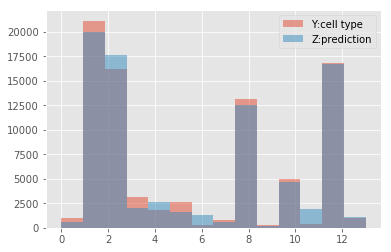

iteration 10 updating cell type assignments
iteration 10  updating model parameters
iteration 10  computing classfication error rate on training data
iteration  10 error rate on training data: 0.059
iteration 20 updating cell type assignments
iteration 20  updating model parameters
iteration 20  computing classfication error rate on training data
iteration  20 error rate on training data: 0.068


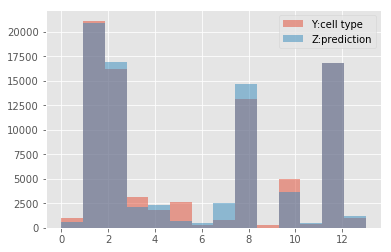

iteration 30 updating cell type assignments
iteration 30  updating model parameters
iteration 30  computing classfication error rate on training data
iteration  30 error rate on training data: 0.072
iteration 40 updating cell type assignments
iteration 40  updating model parameters
iteration 40  computing classfication error rate on training data
iteration  40 error rate on training data: 0.072


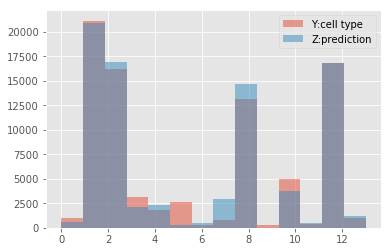

iteration 50 updating cell type assignments
iteration 50  updating model parameters
iteration 50  computing classfication error rate on training data
iteration  50 error rate on training data: 0.072
iteration 60 updating cell type assignments
iteration 60  updating model parameters
iteration 60  computing classfication error rate on training data
iteration  60 error rate on training data: 0.072


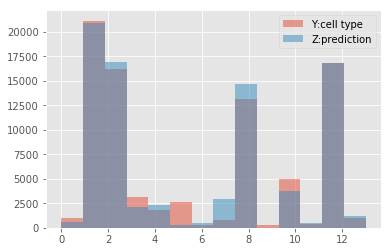

iteration 70 updating cell type assignments
iteration 70  updating model parameters
iteration 70  computing classfication error rate on training data
iteration  70 error rate on training data: 0.072
iteration 80 updating cell type assignments
iteration 80  updating model parameters
iteration 80  computing classfication error rate on training data
iteration  80 error rate on training data: 0.072


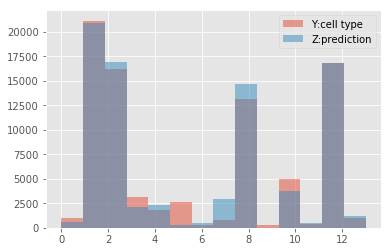

iteration 90 updating cell type assignments
iteration 90  updating model parameters
iteration 90  computing classfication error rate on training data
iteration  90 error rate on training data: 0.072


In [50]:
# create variables for membership of cells, parameters of the model
Z = np.zeros(N).astype(int)
mu_high = np.zeros(D) # mean
mu_low = np.zeros(D) # mean
sigma_high = np.zeros(D) # std
sigma_low = np.zeros(D) # std

# fit 2 dimensional GMM in each dimension for parameter initialization
models = [None for d in range(D)]
for d in range(D):
    models[d] = GaussianMixture(2).fit(X[:,d].reshape(-1, 1))
    
    params = np.array([models[d].means_.reshape(1,-1)[0],models[d].covariances_.reshape(1,-1)[0]])
    if params[0,0] > params[0,1]:
        params = params[:,[1,0]]
    params[1:] = np.sqrt(params[1:])
    mu_low[d] = params[0,0]
    mu_high[d] = params[0,1]
    sigma_low[d] = params[1,0]
    sigma_high[d] = params[1,1]

max_iter = 100
p_k = np.array([1.0/K for _ in range(K)])

for iter in range(max_iter):
    
    if iter % 10 == 0:
        print "iteration %d updating cell type assignments" % iter
        
    ####################### update assignments Z
    ###possible way to speed up: compute N*D matrix for each k and then compare    
    prob = np.zeros([N,K])
    prob += np.log(p_k + 0.000001)
    for k in range(K):
        index = np.where(T[k,:] != 0)[0] # markers that are  + or - 1 for cluster k
        for _ in index:
            if T[k,_] == 1:
                prob[:,k] += gauss_logL(X[:,_], mu_high[_],sigma_high[_])
            if T[k,_] == -1:
                prob[:,k] += gauss_logL(X[:,_], mu_low[_],sigma_low[_])
            prob[:,k] -= kde_scores[:,_]
        
    Z = np.argmax(prob, axis=1)                
    # compute P(z_i = k)
    p_k = np.array([sum(Z==k)*1.0/N for k in range(K)])
    
    if iter % 10 == 0:
        print "iteration %d  updating model parameters" % iter
    
    ####################### update model parameters
    for j in range(D):
        index_high = np.array([i for i in range(N) if Z[i] in marker2cluster[j]['high']])
        if len(index_high) > 0:
            mu_high[j] = np.mean(X[index_high,j])
            sigma_high[j] = np.std(X[index_high,j])
        index_low = np.array([i for i in range(N) if Z[i] in marker2cluster[j]['low']])
        if len(index_low) > 0:
            mu_low[j] = np.mean(X[index_low,j])
            sigma_low[j] = np.std(X[index_low,j])
            
    ###################### compute clssfication error on training data
    
    if iter % 10 == 0:
        print "iteration %d  computing classfication error rate on training data" % iter
        error_rate = sum(Y != Z)*1.0/ N
        print "iteration % d error rate on training data: %.3f" % (iter,error_rate)

    if iter % 20 == 0:
        bins = K
        plt.hist(Y, bins, alpha=0.5, label='Y:cell type')
        plt.hist(Z, bins, alpha=0.5, label='Z:prediction')
        plt.legend(loc='upper right')
        plt.show()